# Demo Notebook how to run models on static mouse datasets

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 

In [2]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USER']
dj.config['database.password'] = os.environ['DJ_PASS']
dj.config['enable_python_native_blobs'] = True

name = "test"
dj.config['schema_name'] = f"konstantin_nnsysident_{name}"

In [8]:
import torch
import numpy as np
import pickle 
import pandas as pd
from collections import OrderedDict, Iterable
import matplotlib.pyplot as plt

import nnfabrik
from nnfabrik.main import *
from nnfabrik import builder

from nnsysident.tables.experiments import *
from nnsysident.datasets.mouse_loaders import static_shared_loaders
from nnsysident.datasets.mouse_loaders import static_loaders
from nnsysident.datasets.mouse_loaders import static_loader

# Get Dataloader

In [4]:
# change path here
paths = ['data/static22564-2-12-preproc0.zip',
                     'data/static22564-2-13-preproc0.zip',
                     'data/static22564-3-8-preproc0.zip',
                     'data/static22564-3-12-preproc0.zip']

#paths = ['data/static22564-2-12-preproc0.zip']
dataset_fn = 'nnsysident.datasets.mouse_loaders.static_shared_loaders'
dataset_config = dict(
    paths=paths,
    batch_size=64,
    seed=1,
    #image_n=50,
    #image_base_seed=1,
    multi_match_n=972,
    multi_match_base_seed=1,
    exclude_multi_match_n = 3625,

)

dataloaders = builder.get_data(dataset_fn, dataset_config)

data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip
data/static22564-2-12-preproc0 exists already. Not unpacking data/static22564-2-12-preproc0.zip
data/static22564-2-13-preproc0 exists already. Not unpacking data/static22564-2-13-preproc0.zip
data/static22564-3-8-preproc0 exists already. Not unpacking data/static22564-3-8-preproc0.zip
data/static22564-3-12-preproc0 exists already. Not unpacking data/static22564-3-12-preproc0.zip


# Get Model

### The New gaussian readout: change gauss_type for the different modes

In [5]:
model_fn = 'nnsysident.models.models.se2d_fullgaussian2d'

model_config = {#'share_features': True,
                #'share_transform': True,
                 'init_mu_range': 0.55,
                 'init_sigma': 0.4,
                 'input_kern': 15,
                 'hidden_kern': 13,
                 'gamma_input': 1.0,
                 'gamma_readout': 0.333593, #2.117604964706911, #626.6499356203459, # 2.117604964706911, #626.6499356203459
                 'grid_mean_predictor': {'type': 'cortex',
                                          'input_dimensions': 2,
                                          'hidden_layers': 0,
                                          'hidden_features': 0,
                                          'final_tanh': False,
                                        }}


model = builder.get_model(model_fn=model_fn, model_config=model_config, dataloaders=dataloaders, seed=1)
model_real = builder.get_model(model_fn=model_fn, model_config=model_config, dataloaders=dataloaders, seed=1)
model_start = builder.get_model(model_fn=model_fn, model_config=model_config, dataloaders=dataloaders, seed=1)

In [ ]:
#core_dict = OrderedDict([(k, v) for k, v in torch.load('dfc6a9fbcca790d7a6b59ff787d96356.pth.tar').items() if k[0:5] == 'core.'])
core_dict = torch.load('21ee7ec25ed7fc959838386c61f5c91a.pth.tar')

def get_grids(my_model):
    grids = {}
    for key, readout in my_model.readout.items():
        grid = readout.grid.squeeze().cpu().data.numpy()
        grids[key] = grid
    return grids

list_of_load = [] #'scales', '_features' ,'mu_transform.0.weight', 'mu_transform.0.bias'
list_of_detach = []



model_real.load_state_dict(core_dict, strict=False)
real_grids = get_grids(model_real)

remove=[]
keep=[]
for key in core_dict.keys():
    name = '.'.join(key.split('.')[2:])
    if key.split('.')[0] == 'readout': 
        if not np.isin(name, list_of_load):
            print('Not loading:    {}'.format(key))
            remove.append(key)
        else:
            keep.append(key)
for key in keep:
    print('Loading:  {}'.format(key))

for k in remove: del core_dict[k]
model_start.load_state_dict(core_dict, strict=False)
start_grids = get_grids(model_start)



model.load_state_dict(core_dict, strict=False)

for param in model.named_parameters():
    name = '.'.join(param[0].split('.')[2:])
    if param[0].split('.')[0] == 'readout':
        if np.isin(name, list_of_detach):
            print('detaching:    {}'.format(param[0]))
            param[1].requires_grad = False

# Get Trainer

In [6]:
trainer_fn = 'nnsysident.training.trainers.standard_trainer'
trainer_config = dict(track_training=True) #detach_core=True, 
trainer = builder.get_trainer(trainer_fn, trainer_config)

# Run Training

In [7]:
score, output, model_state = trainer(model=model, dataloaders=dataloaders, seed=1)

correlation -0.0005704157
poisson_loss 2396836.0


Epoch 1: 100%|██████████| 280/280 [00:27<00:00, 10.34it/s]


[001|00/05] ---> 0.11309714615345001
correlation 0.113097146
poisson_loss 1220247.9


Epoch 2: 100%|██████████| 280/280 [00:10<00:00, 27.54it/s]


[002|00/05] ---> 0.1547965109348297
correlation 0.15479651
poisson_loss 1188704.8


Epoch 3: 100%|██████████| 280/280 [00:10<00:00, 27.36it/s]


[003|00/05] ---> 0.21514227986335754
correlation 0.21514228
poisson_loss 1134204.5


Epoch 4: 100%|██████████| 280/280 [00:09<00:00, 29.34it/s]


[004|00/05] ---> 0.25191575288772583
correlation 0.25191575
poisson_loss 1103319.2


Epoch 5: 100%|██████████| 280/280 [00:09<00:00, 28.66it/s]


[005|00/05] ---> 0.27379804849624634
correlation 0.27379805
poisson_loss 1082897.4


Epoch 6: 100%|██████████| 280/280 [00:09<00:00, 28.82it/s]


[006|00/05] ---> 0.2898118495941162
correlation 0.28981185
poisson_loss 1069848.0


Epoch 7: 100%|██████████| 280/280 [00:09<00:00, 28.25it/s]


[007|00/05] ---> 0.3024550676345825
correlation 0.30245507
poisson_loss 1057255.0


Epoch 8: 100%|██████████| 280/280 [00:09<00:00, 29.25it/s]


[008|00/05] ---> 0.3098908066749573
correlation 0.3098908
poisson_loss 1051206.6


Epoch 9: 100%|██████████| 280/280 [00:09<00:00, 28.06it/s]


[009|00/05] ---> 0.31490558385849
correlation 0.31490558
poisson_loss 1044440.75


Epoch 10: 100%|██████████| 280/280 [00:09<00:00, 29.19it/s]


[010|00/05] ---> 0.3183201551437378
correlation 0.31832016
poisson_loss 1042652.0


Epoch 11: 100%|██████████| 280/280 [00:09<00:00, 28.32it/s]


[011|00/05] ---> 0.3235459625720978
correlation 0.32354596
poisson_loss 1036816.75


Epoch 12: 100%|██████████| 280/280 [00:09<00:00, 29.21it/s]


[012|00/05] ---> 0.3249955177307129
correlation 0.32499552
poisson_loss 1036295.2


Epoch 13: 100%|██████████| 280/280 [00:09<00:00, 29.10it/s]


[013|00/05] ---> 0.32829827070236206
correlation 0.32829827
poisson_loss 1036158.9


Epoch 14: 100%|██████████| 280/280 [00:09<00:00, 28.81it/s]


[014|00/05] ---> 0.3322948217391968
correlation 0.33229482
poisson_loss 1030575.9


Epoch 15: 100%|██████████| 280/280 [00:09<00:00, 28.59it/s]


[015|01/05] -/-> 0.3310270607471466
correlation 0.33102706
poisson_loss 1029810.1


Epoch 16: 100%|██████████| 280/280 [00:09<00:00, 28.76it/s]


[016|01/05] ---> 0.3354929983615875
correlation 0.335493
poisson_loss 1027275.6


Epoch 17: 100%|██████████| 280/280 [00:09<00:00, 28.79it/s]


[017|00/05] ---> 0.3389400243759155
correlation 0.33894002
poisson_loss 1024027.1


Epoch 18: 100%|██████████| 280/280 [00:09<00:00, 28.74it/s]


[018|01/05] -/-> 0.33787211775779724
correlation 0.33787212
poisson_loss 1024703.3


Epoch 19: 100%|██████████| 280/280 [00:09<00:00, 28.72it/s]


[019|01/05] ---> 0.34107255935668945
correlation 0.34107256
poisson_loss 1022772.44


Epoch 20: 100%|██████████| 280/280 [00:09<00:00, 29.22it/s]


[020|00/05] ---> 0.34278494119644165
correlation 0.34278494
poisson_loss 1019761.4


Epoch 21: 100%|██████████| 280/280 [00:09<00:00, 29.17it/s]


[021|00/05] ---> 0.3437415361404419
correlation 0.34374154
poisson_loss 1019640.6


Epoch 22: 100%|██████████| 280/280 [00:09<00:00, 29.21it/s]


[022|01/05] -/-> 0.3418370485305786
correlation 0.34183705
poisson_loss 1023405.5


Epoch 23: 100%|██████████| 280/280 [00:09<00:00, 28.82it/s]


[023|01/05] ---> 0.3459073603153229
correlation 0.34590736
poisson_loss 1017033.75


Epoch 24: 100%|██████████| 280/280 [00:09<00:00, 28.74it/s]


[024|00/05] ---> 0.34656208753585815
correlation 0.3465621
poisson_loss 1017594.2


Epoch 25: 100%|██████████| 280/280 [00:09<00:00, 29.13it/s]


[025|00/05] ---> 0.3477868437767029
correlation 0.34778684
poisson_loss 1015707.9


Epoch 26: 100%|██████████| 280/280 [00:09<00:00, 29.21it/s]


[026|00/05] ---> 0.35047584772109985
correlation 0.35047585
poisson_loss 1013620.9


Epoch 27: 100%|██████████| 280/280 [00:09<00:00, 29.20it/s]


[027|01/05] -/-> 0.34939369559288025
correlation 0.3493937
poisson_loss 1015450.9


Epoch 28: 100%|██████████| 280/280 [00:09<00:00, 29.24it/s]


[028|01/05] ---> 0.3524537682533264
correlation 0.35245377
poisson_loss 1011884.9


Epoch 29: 100%|██████████| 280/280 [00:09<00:00, 29.12it/s]


[029|01/05] -/-> 0.3508850932121277
correlation 0.3508851
poisson_loss 1014482.44


Epoch 30: 100%|██████████| 280/280 [00:09<00:00, 28.72it/s]


[030|02/05] -/-> 0.3512657880783081
correlation 0.3512658
poisson_loss 1012317.75


Epoch 31: 100%|██████████| 280/280 [00:09<00:00, 28.86it/s]


[031|03/05] -/-> 0.3503999710083008
correlation 0.35039997
poisson_loss 1014537.9


Epoch 32: 100%|██████████| 280/280 [00:09<00:00, 29.18it/s]


[032|03/05] ---> 0.35305967926979065
correlation 0.35305968
poisson_loss 1012613.1


Epoch 33: 100%|██████████| 280/280 [00:09<00:00, 29.20it/s]


[033|01/05] -/-> 0.35215070843696594
correlation 0.3521507
poisson_loss 1011964.0


Epoch 34: 100%|██████████| 280/280 [00:09<00:00, 29.22it/s]


[034|01/05] ---> 0.3552805483341217
correlation 0.35528055
poisson_loss 1007815.0


Epoch 35: 100%|██████████| 280/280 [00:09<00:00, 29.20it/s]


[035|00/05] ---> 0.3564826250076294
correlation 0.35648263
poisson_loss 1006674.5


Epoch 36: 100%|██████████| 280/280 [00:09<00:00, 28.98it/s]


[036|00/05] ---> 0.35734444856643677
correlation 0.35734445
poisson_loss 1005073.75


Epoch 37: 100%|██████████| 280/280 [00:09<00:00, 28.77it/s]


[037|01/05] -/-> 0.35639575123786926
correlation 0.35639575
poisson_loss 1007119.3


Epoch 38: 100%|██████████| 280/280 [00:09<00:00, 28.82it/s]


[038|01/05] ---> 0.35753652453422546
correlation 0.35753652
poisson_loss 1007135.3


Epoch 39: 100%|██████████| 280/280 [00:09<00:00, 29.08it/s]


[039|01/05] -/-> 0.35676392912864685
correlation 0.35676393
poisson_loss 1006939.75


Epoch 40: 100%|██████████| 280/280 [00:09<00:00, 29.17it/s]


[040|02/05] -/-> 0.35747095942497253
correlation 0.35747096
poisson_loss 1005651.0


Epoch 41: 100%|██████████| 280/280 [00:09<00:00, 29.18it/s]


[041|03/05] -/-> 0.3563075661659241
correlation 0.35630757
poisson_loss 1008416.3


Epoch 42: 100%|██████████| 280/280 [00:09<00:00, 29.03it/s]


[042|03/05] ---> 0.35770756006240845
correlation 0.35770756
poisson_loss 1005803.5


Epoch 43: 100%|██████████| 280/280 [00:09<00:00, 28.76it/s]


[043|00/05] ---> 0.3581940233707428
correlation 0.35819402
poisson_loss 1005232.7


Epoch 44: 100%|██████████| 280/280 [00:09<00:00, 28.94it/s]


[044|00/05] ---> 0.3599502146244049
correlation 0.3599502
poisson_loss 1003489.25


Epoch 45: 100%|██████████| 280/280 [00:09<00:00, 29.22it/s]


[045|01/05] -/-> 0.35809046030044556
correlation 0.35809046
poisson_loss 1008186.1


Epoch 46: 100%|██████████| 280/280 [00:09<00:00, 29.10it/s]


[046|01/05] ---> 0.36009714007377625
correlation 0.36009714
poisson_loss 1003935.75


Epoch 47: 100%|██████████| 280/280 [00:09<00:00, 29.23it/s]


[047|01/05] -/-> 0.35949793457984924
correlation 0.35949793
poisson_loss 1003772.4


Epoch 48: 100%|██████████| 280/280 [00:09<00:00, 28.99it/s]


[048|01/05] ---> 0.36060428619384766
correlation 0.3606043
poisson_loss 1004007.25


Epoch 49: 100%|██████████| 280/280 [00:09<00:00, 28.74it/s]


[049|00/05] ---> 0.3607367277145386
correlation 0.36073673
poisson_loss 1003994.0


Epoch 50: 100%|██████████| 280/280 [00:09<00:00, 28.86it/s]


[050|01/05] -/-> 0.3595927953720093
correlation 0.3595928
poisson_loss 1003886.7


Epoch 51: 100%|██████████| 280/280 [00:09<00:00, 29.18it/s]


[051|01/05] ---> 0.36121052503585815
correlation 0.36121053
poisson_loss 1002703.9


Epoch 52: 100%|██████████| 280/280 [00:09<00:00, 29.25it/s]


[052|01/05] -/-> 0.3612014651298523
correlation 0.36120147
poisson_loss 1001978.5


Epoch 53: 100%|██████████| 280/280 [00:09<00:00, 29.34it/s]


[053|02/05] -/-> 0.3594902753829956
correlation 0.35949028
poisson_loss 1004312.6


Epoch 54: 100%|██████████| 280/280 [00:09<00:00, 29.34it/s]


[054|03/05] -/-> 0.3599136173725128
correlation 0.35991362
poisson_loss 1004144.1


Epoch 55: 100%|██████████| 280/280 [00:09<00:00, 28.82it/s]


[055|04/05] -/-> 0.3566127121448517
correlation 0.3566127
poisson_loss 1008255.5


Epoch 56: 100%|██████████| 280/280 [00:09<00:00, 29.04it/s]


[056|05/05] -/-> 0.360947847366333
Restoring best model after lr decay! 0.360948 ---> 0.361211
correlation 0.36121053
poisson_loss 1002703.9


Epoch 57: 100%|██████████| 280/280 [00:09<00:00, 29.38it/s]


Epoch    57: reducing learning rate of group 0 to 1.5000e-03.
[057|01/05] -/-> 0.3603111505508423
correlation 0.36031115
poisson_loss 1004223.75


Epoch 58: 100%|██████████| 280/280 [00:09<00:00, 29.43it/s]


[058|01/05] ---> 0.36487531661987305
correlation 0.36487532
poisson_loss 998074.25


Epoch 59: 100%|██████████| 280/280 [00:09<00:00, 29.42it/s]


[059|01/05] -/-> 0.36428824067115784
correlation 0.36428824
poisson_loss 999784.6


Epoch 60: 100%|██████████| 280/280 [00:09<00:00, 29.42it/s]


[060|02/05] -/-> 0.3638007640838623
correlation 0.36380076
poisson_loss 1000165.06


Epoch 61: 100%|██████████| 280/280 [00:09<00:00, 29.41it/s]


[061|03/05] -/-> 0.36395028233528137
correlation 0.36395028
poisson_loss 999154.25


Epoch 62: 100%|██████████| 280/280 [00:09<00:00, 29.03it/s]


[062|04/05] -/-> 0.36237457394599915
correlation 0.36237457
poisson_loss 1004249.1


Epoch 63: 100%|██████████| 280/280 [00:09<00:00, 28.85it/s]


[063|05/05] -/-> 0.3633410334587097
Restoring best model after lr decay! 0.363341 ---> 0.364875
correlation 0.36487532
poisson_loss 998074.25


Epoch 64: 100%|██████████| 280/280 [00:09<00:00, 29.26it/s]


Epoch    64: reducing learning rate of group 0 to 4.5000e-04.
[064|01/05] -/-> 0.36357128620147705
correlation 0.3635713
poisson_loss 999771.25


Epoch 65: 100%|██████████| 280/280 [00:09<00:00, 29.41it/s]


[065|01/05] ---> 0.3656022548675537
correlation 0.36560225
poisson_loss 997769.6


Epoch 66: 100%|██████████| 280/280 [00:09<00:00, 29.40it/s]


[066|01/05] -/-> 0.3641390800476074
correlation 0.36413908
poisson_loss 999521.9


Epoch 67: 100%|██████████| 280/280 [00:09<00:00, 29.14it/s]


[067|02/05] -/-> 0.36495107412338257
correlation 0.36495107
poisson_loss 998945.1


Epoch 68: 100%|██████████| 280/280 [00:09<00:00, 28.73it/s]


[068|03/05] -/-> 0.3634563982486725
correlation 0.3634564
poisson_loss 1002022.0


Epoch 69: 100%|██████████| 280/280 [00:09<00:00, 28.64it/s]


[069|04/05] -/-> 0.36492130160331726
correlation 0.3649213
poisson_loss 999144.25


Epoch 70: 100%|██████████| 280/280 [00:09<00:00, 28.60it/s]


[070|05/05] -/-> 0.36443817615509033
Restoring best model after lr decay! 0.364438 ---> 0.365602
Restoring best model! 0.365602 ---> 0.365602


Best old:                                  0.376 - 0.379  
Best new (no shared position):             0.377  
Best new (with shared position):           0.373510  
Best new (randomized feature sharing):     0.254705  

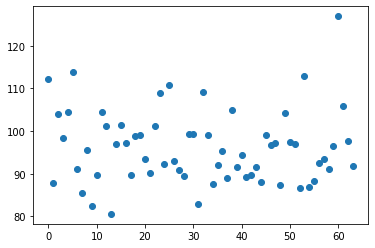

In [51]:
from sklearn.preprocessing import normalize

for readout in model.readout.values():
    pass
features = readout.features.data.cpu().numpy().squeeze()
norm = np.linalg.norm(features, axis=0)
normal_features = features/norm
feature_array = np.sum(np.abs(normal_features), axis=1)

plt.scatter(range(len(feature_array)), feature_array)

In [43]:
normal_features[:,0]

array([-0.11563224, -0.12169852,  0.00162839, -0.1065565 , -0.09030306,
       -0.26411068, -0.03621688, -0.09414343, -0.16266005,  0.00681304,
       -0.27769265,  0.13791348, -0.26308358, -0.02553603,  0.0522678 ,
       -0.10533423, -0.05172475, -0.04741452, -0.05409338,  0.01615188,
        0.09535952, -0.14356638, -0.01316411, -0.23002908, -0.07901259,
        0.06797612, -0.07570498,  0.01948488, -0.00845967, -0.08727653,
        0.20558682,  0.00917294, -0.2335167 , -0.04591681, -0.08830366,
       -0.05552875,  0.00535848, -0.02143106, -0.2733976 , -0.13957964,
       -0.07051293, -0.01613361,  0.05441431, -0.14538914,  0.15702567,
        0.15543485, -0.03477771, -0.332496  , -0.14007756,  0.04658466,
        0.01440863,  0.06820111,  0.01084944, -0.00145826, -0.12061912,
        0.13777626,  0.09337846, -0.19960046,  0.07085589, -0.0680723 ,
        0.05683012,  0.03414334, -0.1698131 , -0.065088  ], dtype=float32)

In [41]:
feature_array

array([-135.35556 ,  -50.963593, -125.74919 ,  -84.72666 , -112.35507 ,
       -134.65776 ,  -55.806526,  -43.241165,  -82.83416 ,  -33.098206,
        -73.38316 , -111.082596,  -78.482605,  -33.48808 ,  -73.29152 ,
        -98.6774  ,  -82.385475,  -53.60815 ,  -98.230774,  -97.133865,
        -62.973694,  -60.324974, -112.10832 , -121.57855 ,  -77.0879  ,
       -122.5238  ,  -47.3617  ,  -55.475555,  -60.051964, -103.36594 ,
        -85.186844,  -46.68411 , -141.59415 ,  -73.78817 ,  -31.45984 ,
        -62.47406 ,  -57.427086,  -42.575302,  -89.43856 ,  -54.633926,
        -62.706844,  -87.99484 ,  -67.76538 ,  -67.726814,  -39.62183 ,
        -63.28067 ,  -89.67135 ,  -90.27229 ,  -71.67987 , -110.82568 ,
        -83.759964,  -83.16847 ,  -51.610588, -144.86322 ,  -35.956497,
        -57.14802 ,  -74.695076,  -83.96378 ,  -85.036476,  -81.61493 ,
       -167.32788 , -110.395836,  -95.39306 ,  -70.00882 ], dtype=float32)

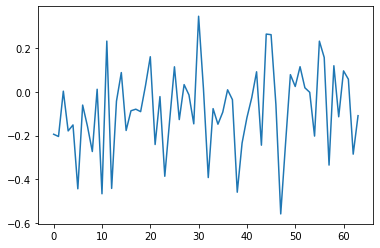

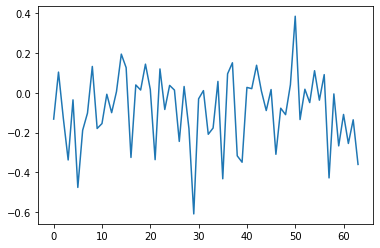

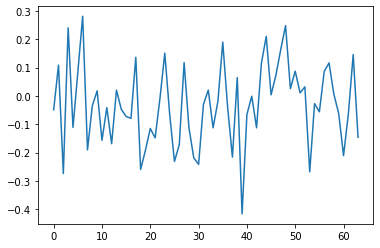

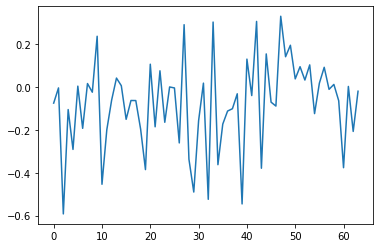

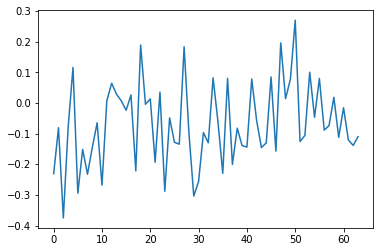

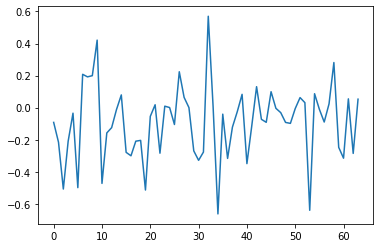

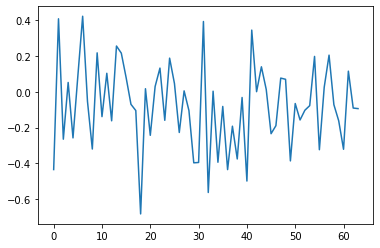

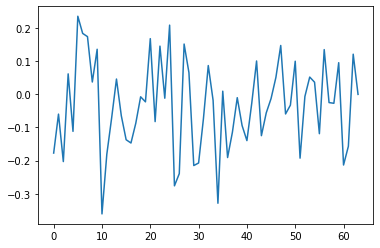

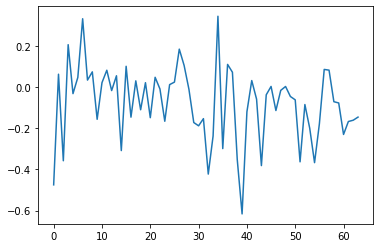

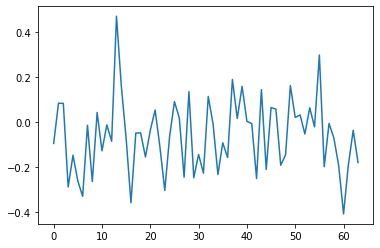

In [52]:
for i in range(10):
    plt.plot(features[:,i])
    plt.show()

(array([2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 4.000e+00, 6.000e+00,
        9.000e+00, 2.200e+01, 3.100e+01, 5.900e+01, 8.300e+01, 1.310e+02,
        2.220e+02, 3.500e+02, 4.710e+02, 7.290e+02, 9.840e+02, 1.391e+03,
        1.787e+03, 2.379e+03, 2.872e+03, 3.470e+03, 4.050e+03, 4.559e+03,
        4.787e+03, 4.898e+03, 5.099e+03, 6.246e+03, 4.429e+03, 3.353e+03,
        2.707e+03, 2.008e+03, 1.560e+03, 1.144e+03, 8.690e+02, 5.920e+02,
        4.430e+02, 2.830e+02, 1.890e+02, 1.300e+02, 8.200e+01, 6.200e+01,
        4.900e+01, 2.200e+01, 1.100e+01, 5.000e+00, 3.000e+00, 4.000e+00,
        2.000e+00, 1.000e+00]),
 array([-1.033639  , -0.9961923 , -0.95874566, -0.921299  , -0.88385236,
        -0.8464057 , -0.808959  , -0.7715124 , -0.7340657 , -0.69661903,
        -0.6591724 , -0.62172574, -0.5842791 , -0.54683244, -0.50938576,
        -0.47193912, -0.43449247, -0.39704582, -0.35959917, -0.3221525 ,
        -0.28470585, -0.2472592 , -0.20981254, -0.17236589, -0.13491923,
        -0.

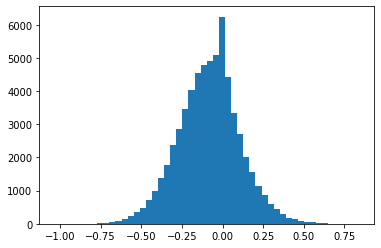

In [50]:
plt.hist(features.flatten(), bins=50)

In [ ]:
grids = get_grids(model)
    
from nnsysident.utility.measures import get_correlations

cors = get_correlations(model, dataloaders['test'], per_neuron=False, as_dict=True)
for key, value in cors.items():
    cors[key] = np.mean(value)

In [ ]:
title = 'feat|scale: random init + learned - position: random 0.33 ortho init|0 + learned + shared'

dictionary = dict(cors=cors,
                  grids = grids,
                  real_grids = real_grids,
                  start_grids = start_grids,)
#torch.save(dictionary, title)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, dpi=200, figsize=(6, 4.3))

for ind, (ax, (key, grid), (real_key, real_grid), (start_key, start_grid)) in enumerate(zip(axes.flat, grids.items(), real_grids.items(), start_grids.items())):
    assert key==real_key==start_key, 'keys do not match'
    ax.scatter(*grid.T, color='navy', s=.1, label='Learned position')
    ax.scatter(*real_grid.T, color='red', s=.1, label='"True" position')
    ax.scatter(*start_grid.T, color='black', s=.1, label='Init position', alpha=0.2)

    ax.set(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1), label='Learned correlation')
    ax.text(-1,.8, round(cors[key], 3), fontsize=8.5, color='navy')
    sns.despine(top=True, ax=ax)
    
    ax.set(xticks=[-1, -.5, 0, .5, 1])
    ax.set_axisbelow(True)
    ax.grid(ls='--')
    if ind != 3:
        ax.set(xticklabels=[], yticklabels=[])
        
    ax.set_title(key, fontsize=10)
fig.suptitle(title.split('-')[0] + '\n' + title.split('-')[-1], y=1.05, fontsize=10.)

plt.tight_layout()
#plt.savefig(title + '.png', dpi=200, bbox_inches='tight')